# Python Toolkit of Statistics for Pairwise Interactions (pyspi): an introduction
### Presented by: Annie Bryant
### CNS 2022
### 16 July 2022

## Preparing the environment

#### Load all the modules needed for this demo

In [8]:
import pandas as pd
import numpy as np
import pickle
import dill
from os import chdir, getcwd
from scipy.stats import zscore
from scipy.signal import detrend
import matplotlib.pyplot as plt # For plotting
from scipy.stats import zscore
import seaborn as sns
from pyspi.calculator import Calculator
from matplotlib import colors, cm

## Preparing the fMRI multivariate time-series (MTS) data

In [5]:
# Load in raw BOLD fMRI time-series data for example subject
# TODO: make this reproducible
ROI_info = pd.read_csv("/media/sf_Shared_Folder/github/CNS_2022/pyspi_tutorial/tutorial_example_data/ROI_info.csv")
BOLD_fMRI_TS_data = pd.read_csv("/media/sf_Shared_Folder/github/CNS_2022/pyspi_tutorial/tutorial_example_data/BOLD_fMRI_TS_example.csv",
                   header = None)
ROI_info = pd.read_csv("/media/sf_Shared_Folder/github/CNS_2022/pyspi_tutorial/tutorial_example_data/ROI_info.csv")

We can view the raw time-series values for these ten regions:

<Figure size 432x288 with 0 Axes>

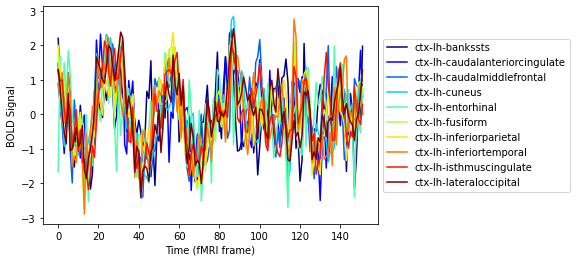

In [9]:
def plot_data_lines(z, labels):
    plt.figure()
    z.transpose().plot(colormap=cm.jet)

    ax = plt.gca()
    ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Time (fMRI frame)')
    plt.ylabel('BOLD Signal')
    plt.show()
    
plot_data_lines(BOLD_fMRI_TS_data, labels = ROI_info.ROI)

We can also view the time series for these ten brain regions as a heatmap:

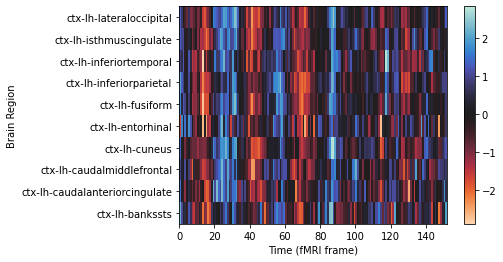

In [6]:
# Plotting the data
def plot_data_heatmap(z, labels):
    plt.subplots()
    plt.pcolormesh(z,cmap=sns.color_palette('icefire_r',as_cmap=True))
    plt.colorbar()

    ticks = [t+0.5 for t in range(len(labels))]
    plt.yticks(ticks=ticks, labels=labels)
    plt.xlabel('Time (fMRI frame)')
    plt.ylabel('Brain Region')
    plt.show()

plot_data_heatmap(BOLD_fMRI_TS_data, labels = ROI_info.ROI)


## Run pyspi

In [ ]:
# These two lines show the main usage of the calculator: simply instantiate and compute.
calc = Calculator(BOLD_fMRI_TS_data, fast=True)
calc.compute()

If you want to use the pre-calculated data, you can simply load it in from the `pyspi_calc.pkl` file:

In [14]:
with open('/media/sf_Shared_Folder/github/CNS_2022/pyspi_tutorial/tutorial_example_data/pyspi_calc.pkl','rb') as f:
    calc = dill.load(f)


We can inspect the resulting statistical pairwise interactions (SPIs) using the `calc.table` object:

In [15]:
print(calc.table)

spi     cov_EmpiricalCovariance                                          \
process                  proc-0    proc-1    proc-2    proc-3    proc-4   
proc-0                      NaN  0.311147  0.208301  0.474260  0.368794   
proc-1                 0.311147       NaN  0.577852  0.632334  0.297841   
proc-2                 0.208301  0.577852       NaN  0.483707  0.383495   
proc-3                 0.474260  0.632334  0.483707       NaN  0.362406   
proc-4                 0.368794  0.297841  0.383495  0.362406       NaN   
proc-5                 0.505125  0.582344  0.667445  0.777725  0.496253   
proc-6                 0.576942  0.569928  0.659017  0.654258  0.424595   
proc-7                 0.328025  0.509604  0.548074  0.666454  0.444860   
proc-8                 0.362476  0.586025  0.776433  0.599530  0.404457   
proc-9                 0.473631  0.624399  0.611111  0.852368  0.431267   

spi                                                        ...  \
process    proc-5    proc-6    pr

This output contains the resulting values from all of the 215 SPIs concatenated together. We can view the list of SPIs that we calculated:

In [ ]:
calc.spis.keys()

We can isolate one of these SPIs and visualize the results across brain regions:

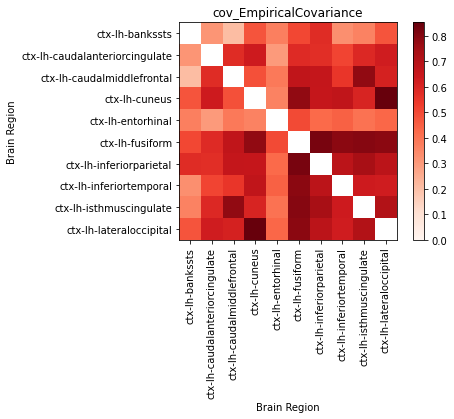

In [23]:
def plot_mpi(S,identifier,labels,ax=None):
    """ Plot a given matrix of pairwise interactions, annotating the process labels and identifier
    """
    if ax is None:
        _, ax = plt.subplots()
    plt.sca(ax)

    # Use a diverging cmap if our statistic goes negative (and a sequential cmap otherwise)
    if np.nanmin(S) < 0.:
        maxabsval = max(abs(np.nanmin(S)),abs(np.nanmax(S)))
        norm = colors.Normalize(vmin=-maxabsval, vmax=maxabsval)
        plt.imshow(S,cmap='coolwarm',norm=norm)
    else:
        plt.imshow(S,cmap='Reds',vmin=0)

    plt.xticks(ticks=range(len(labels)),labels=labels,rotation=90)
    plt.yticks(ticks=range(len(labels)),labels=labels)
    plt.xlabel('Brain Region')
    plt.ylabel('Brain Region')
    plt.title(identifier)
    plt.colorbar()


# Plot this dataframe
plot_mpi(S = calc.table["cov_EmpiricalCovariance"], identifier = "cov_EmpiricalCovariance", labels = ROI_info.ROI)

## Downstream analysis

### Exporting data to R

For users who use R for data wrangling and visualization, we can save the `pyspi` output to a pickle file (`.pkl`) and write a custom function to read this into R with the `reticulate()` package. 

First, save the `calc.table` object to a `.pkl` file:

In [24]:
with open('/media/sf_Shared_Folder/github/CNS_2022/pyspi_tutorial/tutorial_example_data/pyspi_calc_table.pkl', 'wb') as f:
    dill.dump(calc.table, f)

We can then define a separate python script containing a function to extract the SPI data from our `pyspi_calc_table.pkl` file -- found in this repo as `pickle_reader_for_R.py`. Here are the contents: 

In [26]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('/media/sf_Shared_Folder/github/CNS_2022/pyspi_tutorial/pickle_reader_for_R.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))